# Import Require Dependencies

In [1]:
import nltk 
from nltk.tokenize import sent_tokenize,word_tokenize,WhitespaceTokenizer
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer,WordNetLemmatizer,PorterStemmer
from string import punctuation
from unidecode import unidecode
from langdetect import detect
from textblob import TextBlob
from IPython.display import Audio
from autocorrect import Speller
from gtts import gTTS


from langdetect import detect 
from googletrans import Translator
from collections import Counter
from wordcloud import WordCloud
from nltk.util import ngrams,bigrams,trigrams
import contractions
import yake
from rake_nltk import Rake
from sklearn.cluster import KMeans


from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer



import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.metrics import silhouette_score


In [2]:
data = pd.read_csv('D:/PREPARATION/Videos/NLP/dataset_es_train.csv')
data.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics


In [3]:
data.sample(5)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
26945,es_0594630,product_es_0172997,reviewer_es_0323042,1,"Extrañamente tras unos meses de uso, el Iphone...",No compatible,es,pc
25904,es_0636533,product_es_0993801,reviewer_es_0941240,1,Todavia no me ha llegado? Cuando sera! Despues...,Contactar conmigo,es,home
171171,es_0862541,product_es_0334425,reviewer_es_0929347,5,El humidificador es grande con un diseño muy b...,Bonito y poco ruidoso,es,kitchen
17755,es_0332232,product_es_0467881,reviewer_es_0740650,1,No estoy satisfecho no funcionan como deberian...,auriculares,es,wireless
9551,es_0660650,product_es_0221113,reviewer_es_0856289,1,El reloj ha llegado roto! Ni lo pude encender....,Reloj muy malo,es,wireless


In [4]:
data.shape

(200000, 8)

we observed that we have 200000 record and 6 feature

we will choose random 1000 record for fast operation for our project

In [5]:
sample = data.sample(50).reset_index(drop=True)

In [6]:
sample.shape

(50, 8)

after understanding or reading each feature we observed tha the "STARS" and "REVIEW_BODY" is important for our sentiment analysis

In [7]:
df = sample[['stars','review_body']]

In [8]:
df.sample(5)

,stars,review_body
6,2,No me fue bien con mi funda de silicona
18,2,"La funda hace lo que promete , para mi tiene p..."
5,4,"Bien,porque es robusto"
24,5,"Muy buena consola, disfrutándola al maximo"
11,5,"Todo muy bien, gracias"


# Initial Preprocessing

### 1) Language Detection

In [9]:
from langdetect import detect
import warnings
warnings.filterwarnings('ignore')

In [10]:
def get_lang_detect(data):
    lang = detect(data)
    return lang


In [11]:
df['Language'] = df.review_body.apply(get_lang_detect)

In [12]:
df.sample(5)

,stars,review_body,Language
0,5,Buena calidad tal y como esperaba y como se de...,es
47,5,"Me ha gustado mucho, es sólido y tiene compart...",es
37,2,Solo me funciona sin la carcasa original (es u...,es
17,5,Funciona genial. tenia la bateria de la moto g...,es
39,3,"Mi chico usa la talla L normalmente, pero en e...",es


In [13]:
df.Language.unique()           # lang detection may be vary in your case

array(['es', 'pt'], dtype=object)

from above we infer that we detected various language with language code

In [14]:
df.Language.value_counts()

es    48
pt     2
Name: Language, dtype: int64

## 2.Transalation Of Detected Language

In [15]:
from googletrans import Translator

In [16]:
def get_translate(data):
    obj =Translator()
    tran = obj.translate(data)
    return tran.text

In [17]:
df["review_body"] = df["review_body"].apply(get_translate)

In [18]:
df.sample(5)

,stars,review_body,Language
30,5,"It's a good mattress, it's comfortable and res...",es
32,3,New and price thrown,es
4,3,It does not work for all mobile phones and doe...,es
26,2,"It did not work for what I wanted, it has litt...",es
11,5,Everything is fine thanks,es


# EDA

### 1. Ngram

In [19]:
def get_ngram(data,ngram_range):
    tokens = word_tokenize(data)
    ngram = ngrams(tokens,ngram_range)
    n_gram_list =[]
    for i in ngram:
        n_gram_list.append(" ".join(i))
    return n_gram_list


list_unigram =df.review_body.apply(lambda x : get_ngram(x,1))

final_unigram = []
for i in list_unigram:
    final_unigram.extend(i)  # append to list after one another

cnt = Counter(final_unigram).most_common(25)
cnt

[(',', 62),
 ('the', 61),
 ('it', 59),
 ('is', 37),
 ('and', 35),
 ('to', 31),
 ('not', 28),
 ('I', 24),
 ('a', 22),
 ('.', 22),
 ('of', 20),
 ('for', 15),
 ('but', 13),
 ('with', 13),
 ('very', 12),
 ('are', 12),
 ('in', 12),
 ('has', 11),
 ('that', 11),
 ('It', 11),
 ('do', 10),
 ('did', 9),
 ('they', 8),
 ('does', 8),
 ('good', 7)]

In [20]:
def expand_text(data):
    expanded_text = contractions.fix(data)
    return expanded_text

##### Stopword List
remove punctuation ,stopword, and alphanumreic value and some random word whose lenght is less than 2

In [21]:
stopword_list =stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('nor')
stopword_list.remove('not')

def clean_data(data):
    token = word_tokenize(data)
    
    # remove 
    clean_text= [word.lower() for word in token if (word not in punctuation) and (word.lower() not in stopword_list) and (len(word)>2) and (word.isalpha())]
    return clean_text


In [22]:
clean_text = df.review_body.apply(expand_text)

In [23]:
clean_text

0     Good quality as expected and as described by t...
1     The scooter arrived on time.Easy to assemble a...
2     Water pump poor quality, it gets quite stuck.I...
3     The bag very beautiful but I arrive with the z...
4     It does not work for all mobile phones and doe...
5                            Well, because it is robust
6               I did not do well with my silicone case
7     Fatal, lasts 2 days.A bad purchase really.Ther...
8                        The wind broke it in two weeks
9                       Amazon's lousy customer service
10      Do not last stuck in my tiles more than 2 hours
11                            Everything is fine thanks
12    They are very comfortable for the hand and wri...
13                                    It is useless ...
14                          The product, the packaging.
15    Again the company Tourline Express is covered ...
16    A plot without surprises, a fairly common stor...
17    It works great.He had the battery of the s

In [24]:
clean_text.apply(clean_data)

0     [good, quality, expected, described, good, pur...
1     [scooter, arrived, assemble, recommended, chil...
2     [water, pump, poor, quality, gets, quite, plac...
3        [bag, beautiful, arrive, zipper, broken, well]
4        [not, work, mobile, phones, not, say, product]
5                                        [well, robust]
6                           [not, well, silicone, case]
7     [fatal, lasts, bad, purchase, many, cheaper, b...
8                             [wind, broke, two, weeks]
9                    [amazon, lousy, customer, service]
10                     [not, last, stuck, tiles, hours]
11                           [everything, fine, thanks]
12    [comfortable, hand, wrist, horns, also, allow,...
13                                            [useless]
14                                 [product, packaging]
15    [company, tourline, express, covered, false, a...
16    [plot, without, surprises, fairly, common, sto...
17    [works, battery, spent, motorcycle, hours,

In [25]:
list_unigram = clean_text.apply(lambda x :get_ngram("".join(x),1))

final_unigram = []

for word in list_unigram:
    final_unigram.extend(word)
cnt= Counter(final_unigram).most_common()

In [26]:
cnt

[(',', 62),
 ('the', 61),
 ('it', 59),
 ('is', 40),
 ('and', 35),
 ('to', 31),
 ('not', 31),
 ('I', 24),
 ('a', 22),
 ('.', 22),
 ('of', 20),
 ('for', 15),
 ('but', 13),
 ('with', 13),
 ('very', 12),
 ('are', 12),
 ('in', 12),
 ('has', 11),
 ('that', 11),
 ('It', 11),
 ('do', 10),
 ('did', 9),
 ('they', 8),
 ('does', 8),
 ('good', 7),
 ('because', 7),
 ('well', 7),
 ('without', 7),
 ('you', 7),
 ('quality', 6),
 ('The', 6),
 ('had', 6),
 ('me', 6),
 ('as', 5),
 ('product', 5),
 ('recommend', 5),
 ('comfortable', 5),
 ('he', 5),
 ('have', 5),
 ('mobile', 5),
 ('than', 5),
 ('one', 5),
 ('be', 5),
 ('when', 5),
 ('like', 5),
 ('use', 5),
 ('on', 4),
 ('lot', 4),
 ('price', 4),
 ('better', 4),
 ('beautiful', 4),
 ('my', 4),
 ('bad', 4),
 ('more', 4),
 ('...', 4),
 ('this', 4),
 ('can', 4),
 ('put', 4),
 ('by', 3),
 ('quite', 3),
 ('place', 3),
 ('also', 3),
 ('work', 3),
 ('all', 3),
 ('fine', 3),
 ('They', 3),
 ('false', 3),
 ('no', 3),
 ('at', 3),
 ('home', 3),
 ('them', 3),
 ('(', 3),


In [27]:
list_bigram = clean_text.apply(lambda x :get_ngram("".join(x),2))

final_bigram = []

for word in list_bigram:
    final_bigram.extend(word)
cnt= Counter(final_bigram).most_common(25)

In [28]:
cnt

[('it is', 17),
 (', it', 12),
 ('of the', 9),
 ('did not', 8),
 ('do not', 8),
 (', I', 7),
 ('does not', 6),
 ('It is', 6),
 ('it ,', 6),
 ('recommend it', 4),
 ('is very', 4),
 ('a lot', 4),
 ('I did', 4),
 (', the', 4),
 (', a', 4),
 ('to the', 4),
 ('the mobile', 4),
 (', but', 4),
 ('is not', 4),
 ('in the', 4),
 ('by the', 3),
 ('had to', 3),
 ('and the', 3),
 ('for the', 3),
 ('I had', 3)]

In [29]:
list_trigram = clean_text.apply(lambda x :get_ngram("".join(x),3))

final_trigram = []

for word in list_trigram:
    final_trigram.extend(word)
cnt= Counter(final_trigram).most_common(25)

In [30]:
cnt

[(', it is', 5),
 ('I did not', 4),
 ('I do not', 3),
 ('recommend it .', 3),
 ('it is not', 3),
 ('because it is', 2),
 ('it is very', 2),
 (', I have', 2),
 ('a lot of', 2),
 ('I had to', 2),
 ('does not work', 2),
 ('not work for', 2),
 (', I do', 2),
 ('to deliver the', 2),
 (', they do', 2),
 ('they do not', 2),
 ('do not recommend', 2),
 ('not recommend it', 2),
 ('it , I', 2),
 ('did not like', 2),
 ('It is a', 2),
 ('It is very', 2),
 ('to put it', 2),
 ('I am delighted', 2),
 ('that it is', 2)]

In [31]:
star_rating= df[(df.stars<3)].reset_index(drop=True)
star_rating

,stars,review_body,Language
0,2,"Water pump poor quality, it gets quite stuck.I...",es
1,2,I did not do well with my silicone case,es
2,1,"Fatal, lasts 2 days.A bad purchase really.Ther...",es
3,1,The wind broke it in two weeks,es
4,1,Amazon's lousy customer service,es
5,2,Do not last stuck in my tiles more than 2 hours,es
6,1,It is useless ...,pt
7,1,Again the company Tourline Express is covered ...,es
8,2,"A plot without surprises, a fairly common stor...",es
9,2,"The case does what it promises, for me it has ...",es


### try to find what are reason behind less review

In [32]:
star_text=star_rating['review_body'].apply(expand_text)
star_text=star_text.apply(clean_data)
list_trigram = star_text.apply(lambda x : get_ngram(" ".join(x),3))

final_trigram=[]
for i in list_trigram:
    final_trigram.extend(i)


    
    
cnt =Counter(final_trigram).most_common(20)
cnt
    

[('water pump poor', 1),
 ('pump poor quality', 1),
 ('poor quality gets', 1),
 ('quality gets quite', 1),
 ('gets quite place', 1),
 ('quite place plants', 1),
 ('place plants garbage', 1),
 ('plants garbage pond', 1),
 ('garbage pond generated', 1),
 ('pond generated plants', 1),
 ('generated plants disassemble', 1),
 ('plants disassemble several', 1),
 ('disassemble several times', 1),
 ('several times plastic', 1),
 ('times plastic pieces', 1),
 ('plastic pieces starting', 1),
 ('pieces starting also', 1),
 ('starting also makes', 1),
 ('also makes lot', 1),
 ('makes lot noise', 1)]

### 2. Word Cloud

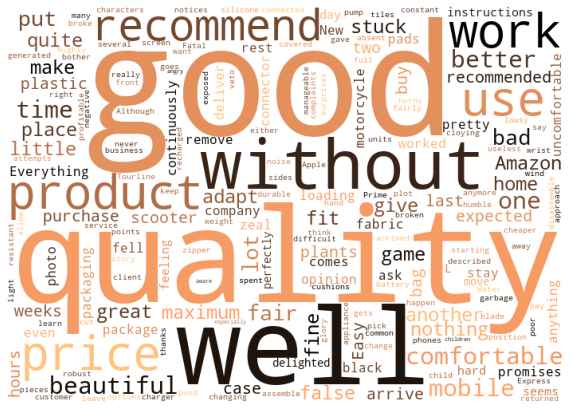

In [33]:
def get_cloud(data,col):
    text =data[col].str.cat(sep=" ")
    text = " ".join([word for word in text.split()])  ## remove extra spaces between  word
    word_cloud= WordCloud(width=700,height=500,background_color="white",colormap='copper_r').generate(text)
    plt.figure(figsize=(10,16))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()

    
    
get_cloud(df,'review_body')

# 3.key_pharase_extraction

In [34]:
def yake_extractor(data):
    key_extractor = yake.KeywordExtractor()
    keyword = key_extractor.extract_keywords(data)
    
    keyword_list =[]
    for i in keyword:
        keyword_list.append(i[0])
    return keyword_list

keywords = df.review_body.apply(yake_extractor)

all_keyword =[]
for kw in keywords:
    all_keyword.extend(kw)


In [35]:
yake= Counter(all_keyword).most_common()
yake

[('quality', 7),
 ('comfortable', 5),
 ('product', 5),
 ('recommend', 5),
 ('good', 5),
 ('beautiful', 4),
 ('bad', 4),
 ('work', 3),
 ('mobile', 3),
 ('fine', 3),
 ('works', 3),
 ('price', 3),
 ('give', 3),
 ('time', 3),
 ('lot', 3),
 ('Good quality', 2),
 ('Good', 2),
 ('expected', 2),
 ('purchase', 2),
 ('case', 2),
 ('buy', 2),
 ('weeks', 2),
 ('hours', 2),
 ('stuck', 2),
 ('opinion', 2),
 ('worked', 2),
 ('home', 2),
 ('fabric', 2),
 ('fair', 2),
 ('maximum', 2),
 ('fits', 2),
 ('instructions', 2),
 ('feeling', 2),
 ('hard', 2),
 ('put', 2),
 ('good quality', 2),
 ('delighted', 2),
 ('perfectly', 2),
 ('good purchase product', 1),
 ('durable and comfortable', 1),
 ('quality as expected', 1),
 ('purchase product', 1),
 ('product I recommend', 1),
 ('good purchase', 1),
 ('durable', 1),
 ('arrived on time.Easy', 1),
 ('time.Easy to assemble', 1),
 ('assemble and quality.Highly', 1),
 ('quality.Highly recommended', 1),
 ('beautiful.The child', 1),
 ('child we gave', 1),
 ('scooter ar

In [36]:
def rake_extractor(data):
    key_extractor =Rake()
    key_extractor.extract_keywords_from_text(data)
    return key_extractor.get_ranked_phrases()

    

keywords = df.review_body.apply(rake_extractor)

yake_keword =[]
for kw in keywords:
    all_keyword.extend(kw)


In [37]:
cnt = Counter(all_keyword).most_common(100)
cnt

[('comfortable', 10),
 ('recommend', 10),
 ('beautiful', 9),
 ('quality', 8),
 ('product', 8),
 ('price', 7),
 ('lot', 7),
 ('work', 6),
 ('mobile', 6),
 ('good', 6),
 ('give', 6),
 ('put', 6),
 ('time', 6),
 ('bad', 5),
 ('fine', 5),
 ('home', 5),
 ('works', 4),
 ('place', 4),
 ('maximum', 4),
 ('feeling', 4),
 ('adapt', 4),
 ('hard', 4),
 ('good quality', 4),
 ('delighted', 4),
 ('use', 4),
 ('expected', 3),
 ('plants', 3),
 ('case', 3),
 ('buy', 3),
 ('stuck', 3),
 ('opinion', 3),
 ('promises', 3),
 ('remove', 3),
 ('loading', 3),
 ('fabric', 3),
 ('fair', 3),
 ('photo', 3),
 ('instructions', 3),
 ('pretty', 3),
 ('well', 3),
 ('like', 3),
 ('good purchase product', 2),
 ('Good quality', 2),
 ('Good', 2),
 ('purchase', 2),
 ('durable', 2),
 ('scooter arrived', 2),
 ('manageable', 2),
 ('scooter', 2),
 ('assemble', 2),
 ('recommended', 2),
 ('child', 2),
 ('gave', 2),
 ('garbage pond generated', 2),
 ('disassemble several times', 2),
 ('plastic pieces', 2),
 ('starting', 2),
 ('noise

# 3.Preprocessing

##### 1.remove space ,newlines

In [38]:
def remove_space(data):
    clean_text = data.replace('\\n',' ').replace('\t',' ').replace('\\'," ")
    return clean_text
clean_space= df.review_body.apply(remove_space)

##### 2. contraction mapping

In [39]:
def get_expanded(data):
    clean_text = contractions.fix(data)
    return clean_text
expanded_text=clean_space.apply(get_expanded)

##### 3.handle accented charactor

In [40]:
def get_handle_accented(data):
    clean_text=unidecode(data)
    return clean_text
accented_clean = expanded_text.apply(get_handle_accented)


##### 4.Autocorrect

In [41]:
def autocorrect(data):
    spell =Speller(lang='en')
    corrected_text= spell(data)
    return corrected_text
autocorrected=accented_clean.apply(autocorrect)


In [42]:
autocorrected

0     Good quality as expected and as described by t...
1     The scooter arrived on time.Easy to assemble a...
2     Water pump poor quality, it gets quite stuck.I...
3     The bag very beautiful but I arrive with the u...
4     It does not work for all mobile phones and doe...
5                            Well, because it is robust
6               I did not do well with my silicone case
7     Fatal, lasts 2 days.A bad purchase really.Ther...
8                        The wind broke it in two weeks
9                       Amazon's lousy customer service
10      Do not last stuck in my tiles more than 2 hours
11                            Everything is fine thanks
12    They are very comfortable for the hand and wri...
13                                    It is useless ...
14                          The product, the packaging.
15    Again the company Touring Express is covered w...
16    A plot without surprises, a fairly common stor...
17    It works great.He had the battery of the s

##### 5.Cleaning

In [43]:
stopword_list = stopwords.words('english')
stopword_list.remove('no')
stopword_list.remove('nor')
stopword_list.remove('not')

def get_clean_data(data):
    token= word_tokenize(data)
    clean_text=[word.lower() for word in token if (word not in punctuation) and (word.lower() not in stopword_list) and (len(word)>2) and (word.isalpha())]
    return clean_text
clean_train_text = accented_clean.apply(get_clean_data)

In [44]:
clean_train_text

0     [good, quality, expected, described, good, pur...
1     [scooter, arrived, assemble, recommended, chil...
2     [water, pump, poor, quality, gets, quite, plac...
3        [bag, beautiful, arrive, zipper, broken, well]
4        [not, work, mobile, phones, not, say, product]
5                                        [well, robust]
6                           [not, well, silicone, case]
7     [fatal, lasts, bad, purchase, many, cheaper, b...
8                             [wind, broke, two, weeks]
9                    [amazon, lousy, customer, service]
10                     [not, last, stuck, tiles, hours]
11                           [everything, fine, thanks]
12    [comfortable, hand, wrist, horns, also, allow,...
13                                            [useless]
14                                 [product, packaging]
15    [company, tourline, express, covered, false, a...
16    [plot, without, surprises, fairly, common, sto...
17    [works, battery, spent, motorcycle, hours,

##### 6.lemmatization

In [45]:
def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    final_data = []
    for word in data :
        lemmatized_word = lemmatizer.lemmatize(word)
        final_data.append(lemmatized_word)
    return " ".join(final_data)    

In [46]:
clean_train_text = clean_train_text.apply(lemmatization)

In [47]:
clean_train_text

0     good quality expected described good purchase ...
1     scooter arrived assemble recommended child gav...
2     water pump poor quality get quite place plant ...
3               bag beautiful arrive zipper broken well
4                 not work mobile phone not say product
5                                           well robust
6                                not well silicone case
7     fatal last bad purchase many cheaper better qu...
8                                   wind broke two week
9                         amazon lousy customer service
10                             not last stuck tile hour
11                               everything fine thanks
12    comfortable hand wrist horn also allow changin...
13                                              useless
14                                    product packaging
15    company tourline express covered false attempt...
16    plot without surprise fairly common story with...
17    work battery spent motorcycle hour connect

# Word Embedding

##### 1.CounterVectorizer

In [48]:
count =CountVectorizer()
bow = count.fit_transform(clean_train_text).A

In [49]:
pd.DataFrame(bow,columns=count.get_feature_names()).head()

,absent,adapt,adheres,ago,allow,also,always,amazon,ancient,angry,...,without,wood,work,worked,worse,worth,would,wrist,zeal,zipper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


##### 2.tfidf

In [50]:
tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(clean_train_text).A
pd.DataFrame(tfidf, columns=tfidf_vect.get_feature_names()).shape

(50, 339)

In [51]:
sent = clean_train_text.tolist()
splitted_sent = [sen.split() for sen in sent]
print(splitted_sent)

[['good', 'quality', 'expected', 'described', 'good', 'purchase', 'product', 'recommend', 'durable', 'comfortable'], ['scooter', 'arrived', 'assemble', 'recommended', 'child', 'gave', 'never', 'scooter', 'learn', 'right', 'away', 'manageable'], ['water', 'pump', 'poor', 'quality', 'get', 'quite', 'place', 'plant', 'garbage', 'pond', 'generated', 'plant', 'disassemble', 'several', 'time', 'plastic', 'piece', 'starting', 'also', 'make', 'lot', 'noise', 'think', 'price', 'better', 'option'], ['bag', 'beautiful', 'arrive', 'zipper', 'broken', 'well'], ['not', 'work', 'mobile', 'phone', 'not', 'say', 'product'], ['well', 'robust'], ['not', 'well', 'silicone', 'case'], ['fatal', 'last', 'bad', 'purchase', 'many', 'cheaper', 'better', 'quality', 'not', 'buy', 'anymore'], ['wind', 'broke', 'two', 'week'], ['amazon', 'lousy', 'customer', 'service'], ['not', 'last', 'stuck', 'tile', 'hour'], ['everything', 'fine', 'thanks'], ['comfortable', 'hand', 'wrist', 'horn', 'also', 'allow', 'changing', '

##### 3.word2vec>>>>Word2Vec requires a list of words

In [101]:
word_2vec_model = Word2Vec(splitted_sent,min_count=2,window=3)

In [102]:
def vectorizer(list_of_docs, model):
    feature = []
    feature_names = []
    for rew in list_of_docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for word in rew:
            if word in model.wv:
                try:
                    vectors.append(model.wv[word])
                    feature_names.append(word)
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            feature.append(avg_vec)
        else:
            feature.append(zero_vector)
    return feature, list(set(feature_names))


In [103]:
vectorized_doc,feature_name = vectorizer(splitted_sent,word_2vec_model)

In [104]:
vectorized_doc

[array([-4.3236017e-03, -3.1997051e-04,  1.0549270e-03,  3.1319913e-04,
         1.3934632e-03, -3.3712084e-03,  1.0742490e-03,  1.8922914e-03,
        -1.7827731e-03, -2.1829829e-03, -3.9877079e-04, -2.5253375e-03,
        -1.9928380e-03,  3.6551390e-04,  1.8949662e-03,  2.7310681e-03,
         4.4017372e-04,  7.6573150e-04,  1.0056177e-03, -2.3182202e-03,
         1.5544597e-04,  2.7958472e-04,  5.9270579e-03, -4.1034888e-03,
         3.7691293e-03,  3.1977766e-03, -2.7660436e-03,  2.0940688e-03,
        -2.9820888e-03,  1.1580288e-03,  5.4058302e-03, -7.6830410e-04,
         2.7340460e-03, -5.8705627e-04,  2.4166127e-04,  1.6308157e-03,
         4.5736489e-04,  2.9204534e-03,  9.7126327e-04,  2.3618829e-03,
         1.6391231e-03, -3.4150475e-04, -5.6788470e-03,  1.2177925e-03,
        -4.1075333e-04, -1.4241857e-03,  1.6877608e-03, -3.5121519e-04,
         1.6623747e-04,  6.8408309e-04,  2.7062295e-03, -1.5872414e-03,
         4.1706994e-04,  1.1376108e-03,  8.0166885e-04,  2.94205

In [105]:
e_emb=np.array(vectorized_doc)
e_emb

array([[-0.0043236 , -0.00031997,  0.00105493, ...,  0.00119454,
        -0.0016917 , -0.00075265],
       [-0.00265064, -0.00524541, -0.00482082, ..., -0.00047725,
         0.00208465,  0.00147429],
       [-0.00093049,  0.00014122, -0.00154603, ...,  0.00239099,
        -0.00297193,  0.00036995],
       ...,
       [-0.00732073,  0.00144184, -0.00777293, ...,  0.00133146,
         0.00151917,  0.0066723 ],
       [ 0.00318708, -0.00276264,  0.00538819, ..., -0.00313133,
         0.00241979,  0.00289655],
       [ 0.00033533,  0.00041703, -0.00015825, ...,  0.00055834,
        -0.00099931,  0.00133697]])

# creating cluster with bow ,tfidf, word2vec

In [106]:
def get_cluster(data,clusters):
    kmean =KMeans(n_clusters=clusters)
    y_pred = kmean.fit_predict(data)
    return kmean,y_pred

In [107]:
# counter_vec with kmean
count_kmean_model,count_pred = get_cluster(bow,3)

In [108]:
count_kmean_model

KMeans(n_clusters=3)

In [109]:
count_pred

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 1, 0])

In [110]:
# tfidf with kmean
tfidf_kmean_model,tfidf_pred = get_cluster(tfidf,3)

In [111]:
tfidf_kmean_model

KMeans(n_clusters=3)

In [112]:
tfidf_pred

array([1, 0, 1, 0, 2, 0, 2, 1, 0, 0, 2, 0, 1, 0, 2, 2, 1, 2, 2, 0, 0, 2,
       0, 1, 1, 1, 2, 0, 2, 2, 1, 0, 0, 0, 2, 0, 2, 2, 1, 2, 2, 0, 1, 2,
       2, 2, 2, 1, 1, 2])

In [113]:
# word2vec with kmean
word2vec_kmean_model,word2vec_pred = get_cluster(e_emb,3)

In [114]:
word2vec_kmean_model

KMeans(n_clusters=3)

In [115]:
word2vec_pred

array([0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 2, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1])

# Evalutuon of cluster

In [116]:
print(f"Silhouette score with kmeans-count : {silhouette_score(bow,count_pred)}")
print(f"Silhouette score with kmeans-tfidf : {silhouette_score(tfidf,tfidf_pred)}")
print(f"Silhouette score with kmeans-word2vec : {silhouette_score(e_emb,word2vec_pred)}")

Silhouette score with kmeans-count : 0.1426904152117599
Silhouette score with kmeans-tfidf : 0.011098198373625301
Silhouette score with kmeans-word2vec : 0.04202579965411204


observation we got best Silhouette score with kmeans-word2vec

In [117]:
def visulize_silhouette(data,model,title1):
    visualizer = SilhouetteVisualizer(model,colors='yellowbrick')
    visualizer.fit(data)
    plt.title(f"Silhouette visualizer for {title1}")

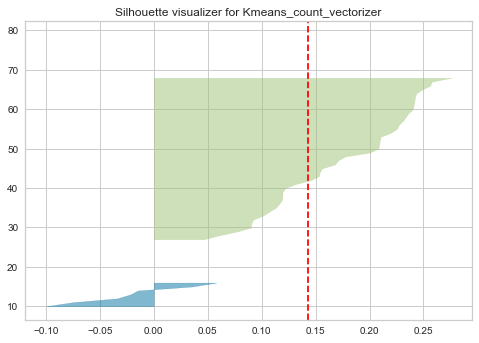

In [118]:
visulize_silhouette(bow,count_kmean_model,'Kmeans_count_vectorizer')

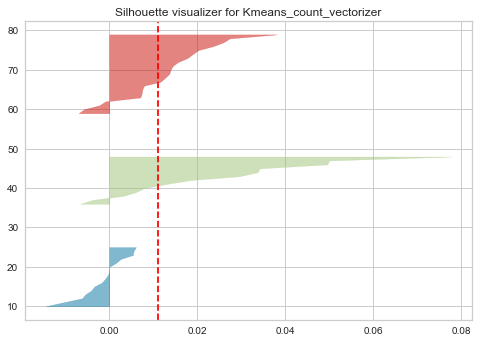

In [119]:
visulize_silhouette(tfidf,tfidf_kmean_model,'Kmeans_count_vectorizer')

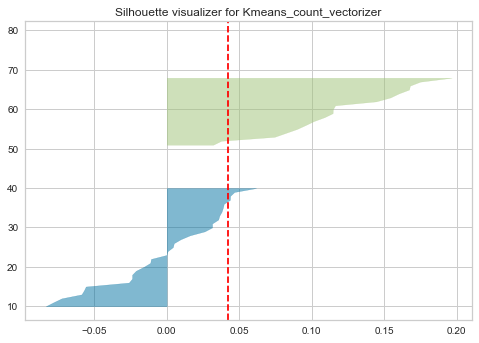

In [120]:

visulize_silhouette(e_emb,word2vec_kmean_model,'Kmeans_count_vectorizer')

# Model Training

In [121]:
x = pd.DataFrame(tfidf,columns=tfidf_vect.get_feature_names())

In [122]:
y= tfidf_pred

In [123]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,BernoulliNB,MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

In [124]:
x_train,x_test,y_train,y_test = train_test_split(x,y,random_state=45,stratify=y)

In [125]:
multi = MultinomialNB()  ## note multinomial does not acccept negative value
multi.fit(x_train,y_train)

MultinomialNB()

## Training

In [126]:
y_pred =multi.predict(x_train)
classification_report_ =classification_report(y_train,y_pred)

In [127]:
print(classification_report_)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        15

    accuracy                           1.00        37
   macro avg       1.00      1.00      1.00        37
weighted avg       1.00      1.00      1.00        37



## Testing

In [128]:
y_pred = multi.predict(x_test)
classification_report_ =classification_report(y_test,y_pred)
print(classification_report_)

              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           1       1.00      0.67      0.80         3
           2       0.60      1.00      0.75         6

    accuracy                           0.69        13
   macro avg       0.87      0.64      0.65        13
weighted avg       0.82      0.69      0.65        13



# Root Cause Analysis

In [129]:
clean_train_text

0     good quality expected described good purchase ...
1     scooter arrived assemble recommended child gav...
2     water pump poor quality get quite place plant ...
3               bag beautiful arrive zipper broken well
4                 not work mobile phone not say product
5                                           well robust
6                                not well silicone case
7     fatal last bad purchase many cheaper better qu...
8                                   wind broke two week
9                         amazon lousy customer service
10                             not last stuck tile hour
11                               everything fine thanks
12    comfortable hand wrist horn also allow changin...
13                                              useless
14                                    product packaging
15    company tourline express covered false attempt...
16    plot without surprise fairly common story with...
17    work battery spent motorcycle hour connect

In [130]:
from nltk.sentiment import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [131]:
df['clean_text'] = clean_train_text

In [132]:
df['sentiment_scores'] = df['clean_text'].apply(lambda x: sid.polarity_scores(x))

In [133]:
df['sentiment'] = df['sentiment_scores'].apply(lambda x: 'positive' if x['compound'] >= 0 else 'negative')

In [142]:
df.head(1)

,stars,review_body,Language,clean_text,sentiment_scores,sentiment
0,5,Good quality as expected and as described by t...,es,good quality expected described good purchase ...,"{'neg': 0.0, 'neu': 0.341, 'pos': 0.659, 'comp...",positive


In [149]:
import yake

In [152]:
from numpy.linalg import norm
def cosine_distance(vect1,vect2):
    distance = (np.dot(vect1,vect2))/(norm(vect1)*norm(vect2))
    return distance

In [153]:

def yake_extractor(data):
    keyword_extractor = yake.KeywordExtractor()
    keywords = keyword_extractor.extract_keywords(data)
    keyword_list = []
    for kw in keywords:
        keyword_list.append(kw[0])
    return keyword_list

In [208]:
key = [yake_extractor(i) for i in df['clean_text']]


In [221]:
key

[['recommend durable comfortable',
  'purchase product recommend',
  'product recommend durable',
  'good quality expected',
  'good purchase product',
  'durable comfortable',
  'quality expected',
  'purchase product',
  'product recommend',
  'recommend durable',
  'good quality',
  'good purchase',
  'expected described good',
  'comfortable',
  'good',
  'quality',
  'expected',
  'purchase',
  'product',
  'recommend'],
 ['arrived assemble recommended',
  'assemble recommended child',
  'recommended child gave',
  'scooter arrived assemble',
  'arrived assemble',
  'assemble recommended',
  'recommended child',
  'child gave',
  'scooter arrived',
  'scooter learn',
  'gave never scooter',
  'manageable',
  'scooter',
  'arrived',
  'assemble',
  'recommended',
  'child',
  'gave',
  'learn'],
 ['water pump poor',
  'pump poor quality',
  'garbage pond generated',
  'time plastic piece',
  'plastic piece starting',
  'make lot noise',
  'place plant garbage',
  'plant garbage pon

In [224]:
root_causes = nltk.FreqDist([word for keyword_list in key for word in keyword_list]).most_common(20)
print(root_causes)

[('good', 6), ('quality', 5), ('product', 5), ('recommend', 5), ('work', 5), ('good quality', 4), ('comfortable', 4), ('bad', 4), ('fair', 3), ('time', 3), ('expected', 2), ('purchase', 2), ('beautiful', 2), ('mobile', 2), ('week', 2), ('hour', 2), ('stuck', 2), ('fine', 2), ('battery', 2), ('fit', 2)]
